<a href="https://colab.research.google.com/github/aminfadaei116/Deep-Learning-Course/blob/master/CA2/Q2_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import cv2
from scipy.io import loadmat
import numpy as np
import tqdm
import torch
import matplotlib.pyplot as plt
import collections
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
img_tensor = torch.load('/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/HW2-DataSet/Q2-DataSet/hazelnut/hazelnut_original_augmentation_good_tensor.pt')
img_tensor = img_tensor.to(device)
crack_tensor = torch.load('/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/HW2-DataSet/Q2-DataSet/hazelnut/hazelnut_original_crack_tensor.pt')
crack_tensor = crack_tensor.to(device)
cut_tensor = torch.load('/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/HW2-DataSet/Q2-DataSet/hazelnut/hazelnut_original_cut_tensor.pt')
cut_tensor = cut_tensor.to(device)
hole_tensor = torch.load('/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/HW2-DataSet/Q2-DataSet/hazelnut/hazelnut_original_hole_tensor.pt')
hole_tensor = hole_tensor.to(device)
print_tensor = torch.load('/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/HW2-DataSet/Q2-DataSet/hazelnut/hazelnut_original_print_tensor.pt')
print_tensor = print_tensor.to(device)

In [ ]:
crack_mask = torch.load('/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/HW2-DataSet/Q2-DataSet/hazelnut/hazelnut_crack_mask.pt')
crack_mask = crack_mask.to(device)
cut_mask = torch.load('/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/HW2-DataSet/Q2-DataSet/hazelnut/hazelnut_cut_mask.pt')
cut_mask = cut_mask.to(device)
hole_mask = torch.load('/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/HW2-DataSet/Q2-DataSet/hazelnut/hazelnut_hole_mask.pt')
hole_mask = hole_mask.to(device)
print_mask = torch.load('/content/drive/My Drive/Deep Learning Course Spring 99/DataSets/HW2-DataSet/Q2-DataSet/hazelnut/hazelnut_print_mask.pt')
print_mask = print_mask.to(device)

In [ ]:
# makes it easy to write user-friendly command-line interfaces
import argparse
# contains data structures for multi-dimensional tensors
# and mathematical operations over theme
import torch
# helps us in creating and training of the neural network.
import torch.nn as nn
# contains all the functions in the torch.nn library
import torch.nn.functional as F
# implements various optimization algorithms
import torch.optim as optim
# contains datasets with almost similar API
from torchvision import datasets
# contains common image transformations
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
# provides several methods to adjust the learning rate based on the number of epochs
from torch.optim.lr_scheduler import StepLR

In [ ]:
class HAZELNUT_IMG(Dataset):
  def __init__(self, img):
    self.img_data = img.view(-1, 3, 256, 256)/256
    self.length = img.shape[0]

  def __getitem__(self, index):
    return self.img_data[index]

  def __len__(self):
    return self.length


In [ ]:
class HAZELNUT_MASK(Dataset):
  def __init__(self, img):
    self.img_data = img.view(-1, 256, 256)/256
    self.img_data[self.img_data >= 0.5] = 1
    self.img_data[self.img_data < 0.5] = 0
    self.length = img.shape[0]

  def __getitem__(self, index):
    return self.img_data[index]

  def __len__(self):
    return self.length


In [ ]:
MyCrackMask = HAZELNUT_MASK(crack_mask)
MyCutMask = HAZELNUT_MASK(cut_mask)
MyHoleMask = HAZELNUT_MASK(hole_mask)
MyPrintMask = HAZELNUT_MASK(print_mask)

In [ ]:
MyTrainDataSet = HAZELNUT_IMG(img_tensor)
MyCrackDataSet = HAZELNUT_IMG(crack_tensor)
MyCutDataSet = HAZELNUT_IMG(cut_tensor)
MyHoleDataSet = HAZELNUT_IMG(hole_tensor)
MyPrintDataSet = HAZELNUT_IMG(print_tensor)

In [ ]:
TrainData = torch.utils.data.DataLoader(dataset=MyTrainDataSet, batch_size=32, shuffle=True)

In [ ]:
class CNN_Net(nn.Module):
  def __init__(self):
    self.loss_graph = []
    super(CNN_Net, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=3, kernel_size=4, stride=2, padding=1),
      nn.BatchNorm2d(3, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.01, inplace=False),
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1),
      nn.BatchNorm2d(32, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.01, inplace=False),
      nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1),
      nn.BatchNorm2d(32, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.01, inplace=False),
      nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.01, inplace=False),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
      nn.BatchNorm2d(64, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.01, inplace=False),
      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.01, inplace=False),
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
      nn.BatchNorm2d(128, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.01, inplace=False),
      nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.01, inplace=False),
      nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.01, inplace=False),
      nn.Conv2d(in_channels=32, out_channels=500, kernel_size=8, stride=1, padding=0),
      nn.BatchNorm2d(500, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.01, inplace=False)
    )
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(in_channels = 500, out_channels = 32, kernel_size=8, stride=1),
      nn.BatchNorm2d(32, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.01, inplace=False),
      nn.ConvTranspose2d(in_channels = 32, out_channels = 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.01, inplace=False),
      nn.ConvTranspose2d(in_channels = 64, out_channels = 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.01, inplace=False),
      nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size=4, stride=2, padding=1),
      nn.BatchNorm2d(64, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.01, inplace=False),
      nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.01, inplace=False),
      nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
      nn.BatchNorm2d(32, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.01, inplace=False),
      nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.01, inplace=False),
      nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1),
      nn.BatchNorm2d(32, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.01, inplace=False),
      nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1),
      nn.LeakyReLU(negative_slope=0.01, inplace=False),
      nn.ConvTranspose2d(in_channels=3, out_channels=3, kernel_size=4, stride=2, padding=1),
      nn.Sigmoid()
    )


  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

  def Train_net(self, learning_rate, epoch_number):
    self.train()
    optimizer = optim.Adam(MyNetwork.parameters(), lr=learning_rate)
    loss_function = nn.MSELoss()
    EPOCHS = epoch_number
    for epoch in range(EPOCHS):
      for i, (inputs) in enumerate(TrainData):
        batch_X = inputs
        optimizer.zero_grad()
        output = MyNetwork(batch_X)
        loss = loss_function(output, batch_X)
        loss.backward()
        optimizer.step()
        print("epoch: ", epoch, " loss for batch: ", loss)

  def Test_single(self, number, Current_DataSet):
    MyNetwork.eval()
    with torch.no_grad():
      result =  MyNetwork.forward(Current_DataSet[number:number+1])
    plt.imshow(result.view(256, 256, 3).cpu().detach().numpy())
    plt.show()
    plt.imshow(Current_DataSet[number].view(256, 256, 3).cpu().detach().numpy())
    plt.show()
    return result


      


In [ ]:
MyNetwork = CNN_Net()
MyNetwork.to(device)


In [ ]:
MyNetwork.Train_net(learning_rate=0.00002, epoch_number=1000)

In [ ]:
MyNetwork.plot_res()

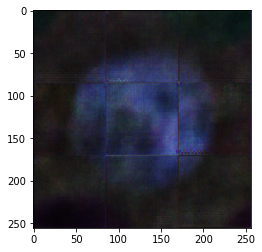

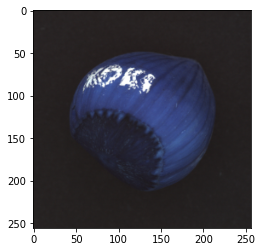

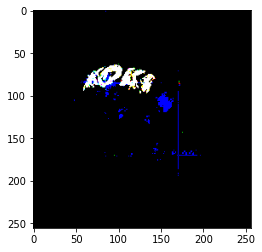

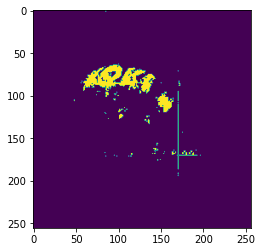

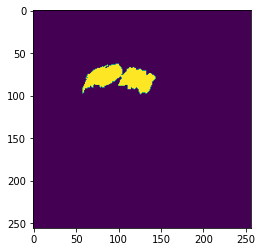

0.7666270783847982
0.6706493506493506
0.9843292236328125


In [ ]:
name = ["crack", "cut", "hole", "print"]
num_img = [18, 17, 18, 17]

num = 1
pred_img = MyNetwork.Test_single_img(num, MyPrintDataSet)
A = (pred_img - MyPrintDataSet[num]).view(256, 256, 3).cpu().detach().numpy()
B = (MyPrintDataSet[num] - pred_img).view(256, 256, 3).cpu().detach().numpy()

threshold = 0.2
A[A>=threshold] = 1
A[A<threshold] = 0
B[B>=threshold] = 1
B[B<threshold] = 0

result = (A + B)
plt.imshow(result)
plt.show()

#binary_res = np.logical_and(result[:,:,0], result[:,:,1], result[:,:,2])
binary_res = np.max(result, axis=2)
plt.imshow(binary_res)
plt.show()

True_mask = MyPrintMask[num].cpu().detach().numpy()
plt.imshow(True_mask)
plt.show()

res = (2 * True_mask-binary_res)
maskTpreF = np.count_nonzero(res == 2)
maskTpreT = np.count_nonzero(res == 1)
maskFpreF = np.count_nonzero(res == 0)
maskFpreT = np.count_nonzero(res == -1.0)



Method1Acc = (maskTpreT/(maskTpreT + maskTpreF))
Method2Acc = (maskTpreT/(maskTpreT + maskFpreT))
Method3Acc = ((maskTpreT + maskFpreF)/(maskTpreT + maskFpreF + maskTpreF + maskFpreT))

print(Method1Acc)
print(Method2Acc)
print(Method3Acc)